In [1]:
import numpy as np
from scipy.ndimage import rotate, zoom
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from scipy.misc import toimage

Write code to augment black-and-white image data.  It should

1. Accept a numpy array X of images (so X[i] is a 2-dimensional array of pixel values corresponding to the ith image), a maximum rotation d (say in degrees), a shift factor s (measured in pixels), a zoom factor z (ranging say from 1 to 2)
2. For each image randomly rotate the image by some amount in (-d, d)
3. For each image, randomly shift up by some number of pixels in (-s,s) and also randomly shift right by some other number of pixels in (-s,s).
4. Randomly zoom in on the center of the image by a factor that is no less than 1/z and no more than z.
5. Return a new array of rotated, shifted, zoomed and padded images.
6. EXTRA CREDIT: fix things so that pixels on the edge that might otherwise default to black (because they are not in the rotated or shifted or zoomed image) are given some appropriate value so that sharp new edges are not introduced by the transformations (that is, if you pad with black, you may well be causing new artifacts that your learner might be confused by, so you want to pad the edge with something less severe--maybe use some sort of smoothing function or use the average of nearby pixels.)

In [28]:
def fix_zoom(array,old_shape,new_shape) :
    n,m = old_shape[0], old_shape[1]
    s,t = new_shape[0], new_shape[1]
    if n > s :
        array = np.vstack((array,np.zeros(n-s,t)))
    elif n < s :
        array = array[:n,:]
    if m > t :
        array = np.hstack((array,np.zeros(n,m-t)))
    elif m < t :
        array = array[:,:m]
    return array

def augment(X, d, s, z):
    #return new array of images
    new_X = np.zeros_like(X)
    for i in range(X.shape[0]) :
        #randomly rotate the image
        rot = 2*d*(np.random.random() - 1/2)
        #randomly zoom
        zo = (z-1/z)*np.random.random() + 1/z
        new = rotate(X[i],angle=rot, reshape=False)
        old_shape = new.shape
        new = zoom(new,zoom=zo)
        new_shape = new.shape
        new = fix_zoom(np.array(new),old_shape,new_shape)
        #randomly shift up
        s1 = int(2*s*(np.random.random() - 1/2)+0.5)
        s_1 = -s1
        #randomly shift right
        s2 = int(2*s*(np.random.random() - 1/2)+0.5)
        s_2 = -s2
        new = np.roll(new,s1,axis=0)
        new = np.roll(new,s2,axis=1)
        new[:s1,:] = np.zeros_like(new[:s1,:])
        new[:,:s2] = np.zeros_like(new[:,:s2])
        new_X[i] = new
    return new_X

Show the results of your augmentation code applied to the first 10 images in the scikit-learn digits dataset (that is, plot the images before and after your code is applied.)

In [29]:
digits = load_digits()
x = digits.images
y = digits.target
#split dataset 60/40
tr_x, ts_x, tr_y, ts_y = train_test_split(x,y,test_size=0.4)
x_new = augment(tr_x,np.pi,2,2)

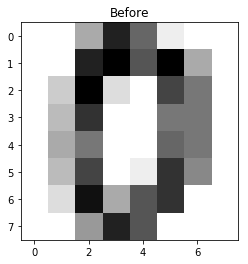

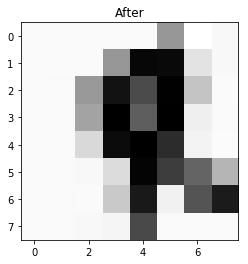

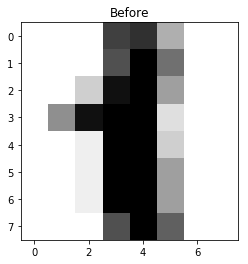

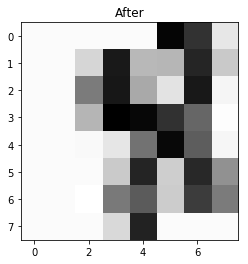

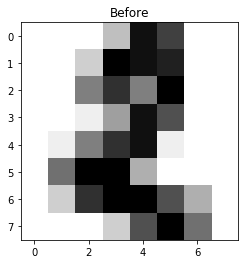

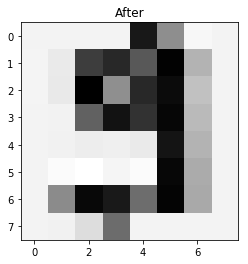

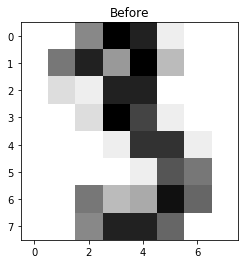

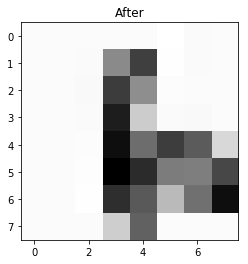

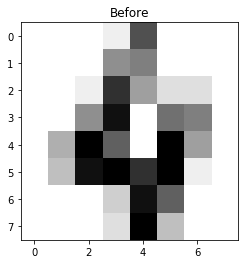

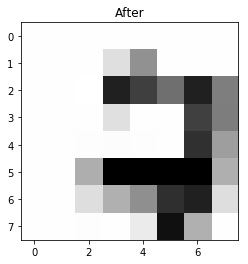

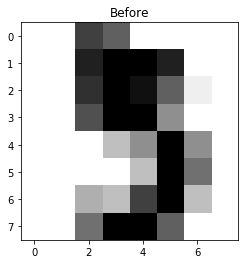

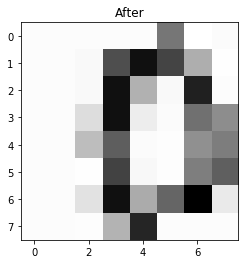

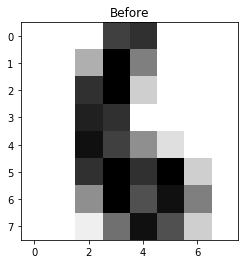

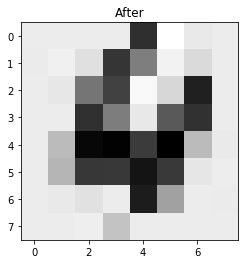

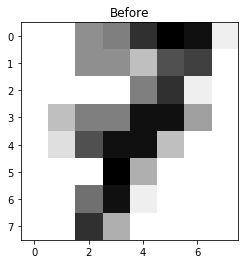

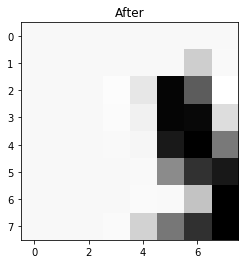

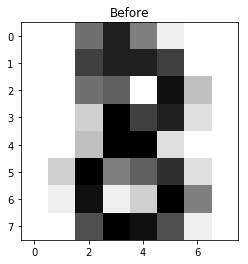

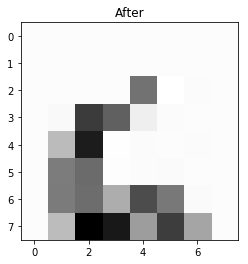

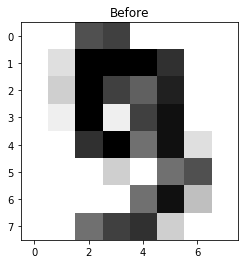

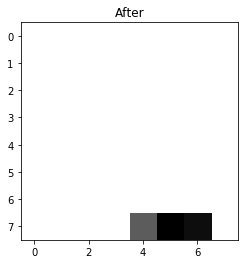

In [30]:
#plot images
for i in range(10) :
    plt.title('Before')
    plt.imshow(toimage(x[i]),cmap=plt.cm.gray_r)
    plt.show()
    plt.title('After')
    plt.imshow(toimage(x_new[i]),cmap=plt.cm.gray_r)
    plt.show()

Split the scikit-learn digits dataset into an 60-40 train-test split and apply your data augmentation code to the training set to make a new training data set that is the original training set AND the augmented data.   Compare (on they test set) the accuracy of a softmax classifier trained on the big data set  versus one trained on the original training set.

In [31]:
def flat(X) :
    n,m,l = X.shape
    flattened = np.zeros((n,m*l))
    for i in range(l) :
        flattened[:,m*i:(m*(i+1))] = X[:,:,i]
    return flattened

In [32]:
#apply code to training set
tr_x_aug = np.vstack((tr_x,x_new))
tr_y_aug = np.hstack((tr_y,tr_y))

classifier = LogisticRegression(C=10e-2,multi_class='multinomial',solver='lbfgs')
classifier.fit(flat(tr_x),tr_y)
res = classifier.predict(flat(ts_x))
orig_acc = 1-np.count_nonzero([res[i]-ts_y[i] for i in range(len(res))])/len(res)

classifier = LogisticRegression(C=10e-2,multi_class='multinomial',solver='lbfgs')
classifier.fit(flat(tr_x_aug),tr_y_aug)
res = classifier.predict(flat(ts_x))
aug_acc = 1-np.count_nonzero([res[i]-ts_y[i] for i in range(len(res))])/len(res)
#compare accuracy
print('Original Accuracy\tAugmented Accuracy')
print(str(orig_acc)+'\t'+str(aug_acc))

Original Accuracy	Augmented Accuracy
0.9652294853963839	0.9179415855354659
